In [1]:
import robin_stocks as r
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
#Log in to Robinhood
robinhood_login = r.login('lkleinbrodt@gmail.com', 'RIPmamba24!robinhood')

#Get Alpaca APIs
with open('api_keys.txt') as api_file:
    api_keys = api_file.read().replace('\n', '').split(',')
    alpaca_api = {a.split('=')[0]: a.split('=')[1] for a in api_keys}

In [3]:
# ### Get Data


# ### Determine which symbols you want:

# # tech_symbols = r.get_all_stocks_from_market_tag('technology', info = 'symbol')
# #pd.DataFrame({'Symbol': tech_symbols}).to_csv('symbols.csv', index = False)

# symbols = pd.read_csv('symbols.csv')['Symbol'].tolist()

# ### Gather Historical Data
# i = 0
# historical_data = []

# while i < len(symbols):
#     history = r.get_stock_historicals(symbols[i:i+50], interval = 'day', span = '5year')
#     historical_data.append(pd.DataFrame(history))
#     i+=50

# history_df = pd.concat(historical_data, axis = 0)
# history_df = history_df[['begins_at', 'open_price', 'close_price', 'high_price', 'low_price', 'symbol']]
# df =  history_df.pivot(index = 'begins_at', columns = 'symbol')
# df.columns = [b+'_'+a for a,b in df.columns]
#df.to_csv('data/historical_data.csv')

In [130]:
df = pd.read_csv('data/historical_data.csv')
df = df.dropna()
#df['Time'] = np.arange(len(df['begins_at']))

#identify the top 50 symbols with highest price


#keep only the open price columns
df = df[[col for col in df.columns if 'close_price' in col]]
#df = df[df.columns[np.argsort(df.sum()).isin(range(25))]]
#keep only the funds with more than 1 unique value in the first year
unique_counts = train_df.head(500).nunique()
df = df[unique_counts.keys()[unique_counts>1].values]
df.head(5)

,ABUS_open_price,ALB_open_price,ARCC_open_price,BB_open_price,BIIB_open_price,BMY_open_price,CVM_open_price,DAN_open_price,HPQ_open_price,IZEA_open_price,MELI_open_price,NNVC_open_price,PAYC_open_price,SHOP_open_price,STM_open_price,TXN_open_price,VMW_open_price,WVE_open_price
0,5.87,52.43,15.59,7.28,257.871199,64.73,14.9875,16.56,14.233271,8.800,101.02,25.80,37.40,31.66,7.58,58.90,58.82,17.05
1,5.99,52.26,15.30,7.26,254.350836,65.50,13.7500,16.48,13.731614,9.000,99.15,25.40,37.28,30.68,7.46,58.39,60.24,17.05
2,6.04,52.16,15.08,7.05,269.049734,66.81,12.9000,16.17,13.534886,8.998,97.53,24.40,36.43,30.89,7.14,58.52,59.47,17.05
3,5.98,53.33,15.24,7.17,271.215402,67.50,13.2500,16.79,13.588987,9.198,96.50,24.80,38.61,30.82,6.73,57.74,60.50,17.05
4,5.83,54.33,15.32,7.14,270.938934,67.35,14.2500,16.67,13.338158,8.202,96.00,24.46,38.91,31.49,6.87,56.99,58.66,17.05


In [131]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [132]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [133]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #Index the labels (and all columns)
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i,name in enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis = -1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, plot_col, model=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time [d]')
    
    def make_dataset(self, data, shuffle = True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32
        )
        ds = ds.map(self.split_window)
        
        return ds

In [134]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [135]:
single_step_window = WindowGenerator(input_width = 1, label_width = 1, shift = 1, label_columns=['ABUS_open_price'])

In [136]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [137]:
baseline = Baseline(label_index=column_indices['ABUS_open_price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 929us/step - loss: 0.0069 - mean_absolute_error: 0.0533


In [138]:
wide_window = WindowGenerator(input_width=20, label_width=20, shift=1)

In [141]:
MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), 
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                        validation_data=window.val,
                        #callbacks=[early_stopping]
                       )
    return history

In [142]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
28/28 [==============================] - 0s 9ms/step - loss: 0.4558 - mean_absolute_error: 0.5143 - val_loss: 0.9613 - val_mean_absolute_error: 0.8918
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0705 - mean_absolute_error: 0.1977 - val_loss: 0.6342 - val_mean_absolute_error: 0.6976
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0317 - mean_absolute_error: 0.1276 - val_loss: 1.0373 - val_mean_absolute_error: 0.9309
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0267 - mean_absolute_error: 0.1158 - val_loss: 0.7236 - val_mean_absolute_error: 0.7740
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0241 - mean_absolute_error: 0.1051 - val_loss: 0.6077 - val_mean_absolute_error: 0.7040
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0227 - mean_absolute_error: 0.1011 - val_loss: 0.5132 - val_mean_absolute_error: 0.6355
Epoch 7/50
28/28 [==========

In [147]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1)

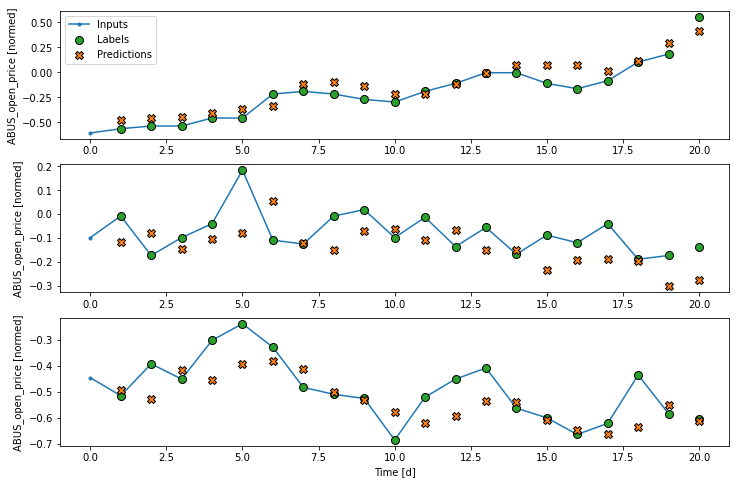

In [144]:
wide_window.plot(plot_col='ABUS_open_price', model = dense)

In [148]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [149]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

8/8 [==============================] - 0s 1ms/step - loss: 4.5344 - mean_absolute_error: 1.7619


In [150]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): None

In [152]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [155]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

8/8 [==============================] - 0s 3ms/step - loss: 0.1115 - mean_absolute_error: 0.2209



In [174]:
compile_and_fit(baseline, wide_window)
baseline.evaluate(wide_window.test, verbose=0)

Epoch 1/50
27/27 [==============================] - 0s 7ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 1.3321 - mean_absolute_error: 0.8831 - val_loss: 8.1612 - val_mean_absolute_error: 2.1088
Epoch 7/50
27/27 [==========

[24.54595184326172, 2.839766025543213]

In [ ]:
n_inputs = wide_window.input_width
n_features = train_df.shape[1]
batch = np.array(test_df[-n_inputs:]).reshape((1, n_input, n_features))
residual_lstm.predict(batch)[0,:,:][-1]